In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-v0_8-darkgrid')
pd.options.mode.chained_assignment = None

### Первичный осмотр данных

In [2]:
df = pd.read_csv('../data/update/data_update.csv', index_col=0)
df.index = pd.to_datetime(df.index)

#проверка на монотоность
df.index.is_monotonic_increasing

True

In [4]:
display(df.info())
display(df.describe())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 268232 entries, 1932-01-01 00:00:00 to 2023-10-18 21:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   kp      268232 non-null  float64
dtypes: float64(1)
memory usage: 4.1 MB


None

,kp
count,268232.000000
mean,2.172398
std,1.452105
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


,kp
datetime,
2023-10-18 09:00:00,2.667
2023-10-18 12:00:00,3.000
2023-10-18 15:00:00,3.000
2023-10-18 18:00:00,2.333
2023-10-18 21:00:00,2.333


В данных пропусков нет.  Медианное значение kp = 2 и даже при 75 процентиле значения kp = 3, что классифицируется как усиленная магнитная буря

Проверка стационарности ряда при помощи критерия Дики-Фуллера

In [6]:
def stationarity(df):
    df_stat = stattools.adfuller(df)
    print(f'Критерий Дики-Фуллера {df_stat[0]}, \npvalue: {df_stat[1]}\ncritical values: {df_stat[4]}')
    
    if df_stat[0] > df_stat[4]['5%']:
        print('Есть единичные корни - ряд нестационарный')
    else:
        print('Единичных корней нет, ряд стационарен')

In [7]:
stationarity(df[-7000:])

Критерий Дики-Фуллера -11.468027889247578, 
pvalue: 5.3513474750539334e-21
critical values: {'1%': -3.431289091493141, '5%': -2.8619550026750646, '10%': -2.5669909019874146}
Единичных корней нет, ряд стационарен


In [10]:
def graf(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(15, 7))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

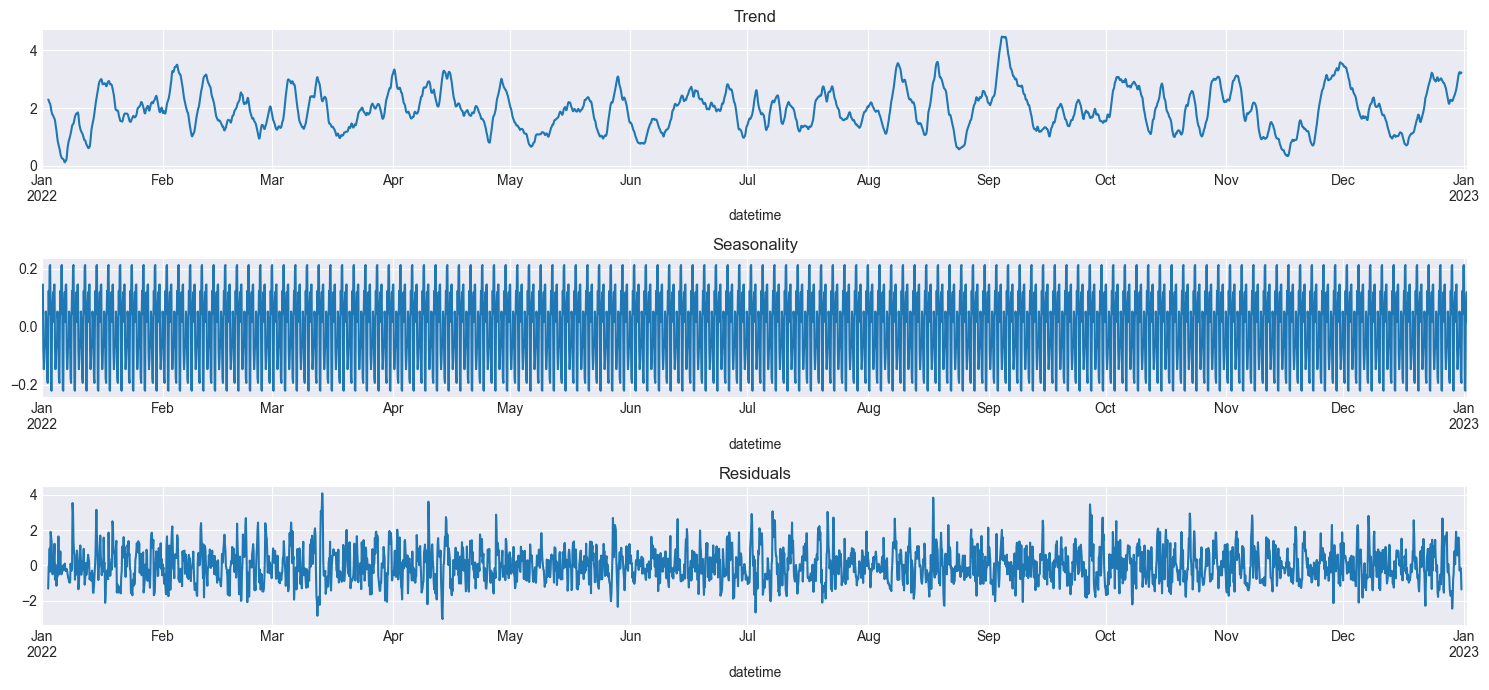

In [11]:
graf(df['2022-01-01': '2023-01-01'])

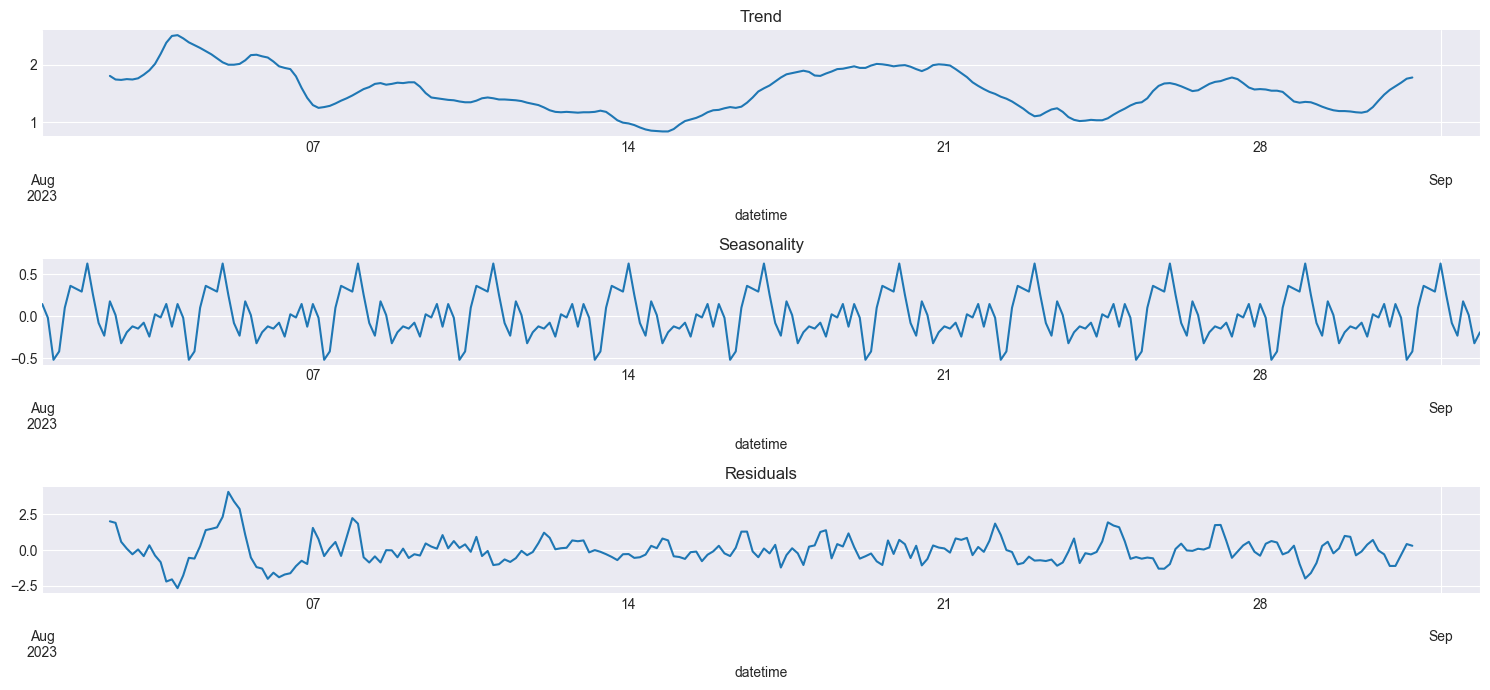

In [12]:
graf(df['2023-08-01':'2023-09-01'])

На графике ярко выделяется сезонность в 3-4 дня

### Качество прогноза

In [13]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions)**0.5

Разделяем выборки на тренировочные и тестовые. По скольку дф тянется с 1932 года можно на тестовую выборку выделить 0.05% данных

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.05)

In [15]:
print(f'Средний kp индекс = {df.kp.mean()}')

pred_median = np.ones(test.shape) * train['kp'].median()
print(f'RMSE в случае предсказания тестовой выборки одним и тем же числом = {rmse(test, pred_median)}')

pred_previous = test.shift(fill_value=train.iloc[-1, 0])['kp']
print(f'RMSE предсказания в случае заполнения ответов предыдущим значением = {rmse(test, pred_previous)}')

Средний kp индекс = 2.1723982559873543
RMSE в случае предсказания тестовой выборки одним и тем же числом = 1.2653291203502914
RMSE предсказания в случае заполнения ответов предыдущим значением = 0.8308831629358865


### Вывод 

По критерию Дикки-Фуллера ряд стационарный. Во время обучения модели мы должны достигнуть RMSE меньше 0.8308